In [1]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
T.set_printoptions(precision=5)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.13093,), (0.30845,))])

In [4]:
# Load MNIST data into MNIST objects
path = '/content/drive/MyDrive/Dataset'
train_dataset = datasets.MNIST(root=path, train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root=path, train=False, download=True, transform=transform)

In [5]:
VALID_SIZE = 0.2
BATCH_SIZE = 32

In [6]:
# train_idx and valid_idx are lists, _ and _ are train_labels and valid_labels (tensors)
train_idx, valid_idx, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify  = train_dataset.targets,
    test_size = VALID_SIZE,
    random_state=42
)

In [7]:
# generate subset instances
train_set = Subset(train_dataset, train_idx)
valid_set = Subset(train_dataset, valid_idx)
len(train_set), len(valid_set) # = (48000, 12000)

(48000, 12000)

In [8]:
# create batches
train_dl = DataLoader(train_set,    batch_size=BATCH_SIZE, shuffle=True) # 48000
valid_dl = DataLoader(valid_set,    batch_size=BATCH_SIZE, shuffle=True) # 12000
test_dl  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)# 10016

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128) # 28*28 = 784
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)            # Size([BATCH_SIZE, 784])
        x = self.fc1(x)
        x = T.relu(x)                  # Size([BATCH_SIZE, 128])
        return self.fc2(x)


In [11]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
EPOCHS = 20
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []
for epoch in range(EPOCHS):
    running_loss = 0
    running_corr = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate (train_dl): # Run the training batches
        total += BATCH_SIZE
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        max_indices = T.max(outputs, 1)[1]
        matches = (max_indices == labels)
        running_corr += matches.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % (10*BATCH_SIZE) == 0:
            print( 'epoch {}, loss: {:.4f}'.format(epoch+1, loss.item()) )

    train_losses.append(running_loss/len(train_dl))
    train_acc.append(running_corr/total)

    # Run the validation
    running_loss = 0.0
    running_corr = 0
    total = 0
    model.eval()
    with T.no_grad():
        for inputs, labels in valid_dl: # valid_loader
            total += labels.size(0)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() # = loss.item() * inputs.size(0)
            max_indices = T.max(outputs.data, 1)[1]
            running_corr += (max_indices == labels).sum().item()

    valid_losses.append(running_loss / len(valid_dl))
    valid_acc.append(running_corr/total)
    print(f'Epoch {epoch+1} loss: {train_losses[-1]:.4f} val_loss: {valid_losses[-1]:.4f}')

epoch 1, loss: 2.3679
epoch 1, loss: 0.3291
epoch 1, loss: 0.3900
epoch 1, loss: 0.1055
epoch 1, loss: 0.0982
Epoch: 1 loss: 0.2449 val_loss: 0.1386
epoch 2, loss: 0.0484
epoch 2, loss: 0.0674
epoch 2, loss: 0.0355
epoch 2, loss: 0.1047
epoch 2, loss: 0.0181
Epoch: 2 loss: 0.1124 val_loss: 0.1237
epoch 3, loss: 0.0919
epoch 3, loss: 0.0087
epoch 3, loss: 0.1306
epoch 3, loss: 0.0380
epoch 3, loss: 0.0788
Epoch: 3 loss: 0.0786 val_loss: 0.0979
epoch 4, loss: 0.0333
epoch 4, loss: 0.0547
epoch 4, loss: 0.0794
epoch 4, loss: 0.1101
epoch 4, loss: 0.0163
Epoch: 4 loss: 0.0584 val_loss: 0.1129
epoch 5, loss: 0.0453
epoch 5, loss: 0.1655
epoch 5, loss: 0.1325
epoch 5, loss: 0.0067
epoch 5, loss: 0.0090
Epoch: 5 loss: 0.0478 val_loss: 0.0907
epoch 6, loss: 0.0021
epoch 6, loss: 0.0293
epoch 6, loss: 0.0408
epoch 6, loss: 0.0123
epoch 6, loss: 0.0385
Epoch: 6 loss: 0.0353 val_loss: 0.1070
epoch 7, loss: 0.0950
epoch 7, loss: 0.0230
epoch 7, loss: 0.0219
epoch 7, loss: 0.0158
epoch 7, loss: 0.1

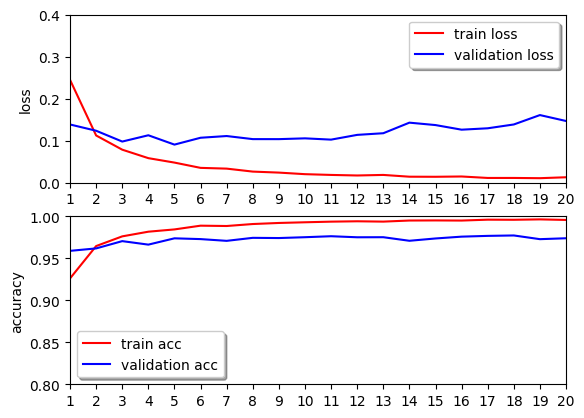

In [13]:
x_range = range(1, EPOCHS+1)

fig, ax = plt.subplots(2,1)
ax[0].plot(x_range, train_losses, color='r', label="train loss")
ax[0].plot(x_range, valid_losses, color='b', label="validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_xlim([1, EPOCHS])
ax[0].set_xticks(range(1, EPOCHS+1))
ax[0].set_ylim([0,0.4])
ax[0].set_ylabel("loss")

ax[1].plot(x_range, train_acc, color='r',label="train acc")
ax[1].plot(x_range, valid_acc,  color='b',label="validation acc")
ax[1].legend(loc='best', shadow=True)
ax[1].set_xlim([1,EPOCHS])
ax[1].set_xticks(x_range)
ax[1].set_ylim([0.8,1])
ax[1].set_ylabel("accuracy")
plt.show()

In [15]:
model.eval()
correct = 0
total = 0
with T.no_grad():
    for images, labels in test_dl:
        total += BATCH_SIZE
        output = model(images)
        _, predicted = T.max(output.data, 1)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total:.4f}%")

Accuracy: 97.4141%


In [16]:
sample_images, _ = next(iter(test_dl))

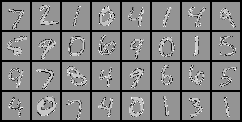

In [17]:
img_grid = utils.make_grid(sample_images)
img = transforms.ToPILImage()(img_grid)
img

In [20]:
# Make predictions
output = model(sample_images)
#output = F.softmax(output, dim=1)
_, pred = T.max(output.data, 1)
print(pred.detach().numpy())

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
